In [1]:
import sympy as sy;
import numpy as np;
from numpy import cos,sin,pi;
from scipy import linalg;
import matplotlib.pyplot as plt;

In [2]:
dim=2;
dtau=0.5;
errmax = pow(10,-4);
itermax = pow(10,3);

In [3]:
### Variables
### x[0], x[1], x[2], x[3], ... , x[dim-1]
### 
x = []
for i in range(dim):
    vname = 'x[' + str(i) +']';
    x.append(sy.symbols(vname));
    
### Source
### f[0], f[1], f[2], ... , f[dim-1]
f = [];
f.append( (x[0]**2 +x[1]**2 -4) );
f.append( (x[0]**2*x[1] -1) );

In [4]:
# input source
def calc_source(x,f):

### Summation of absolute values of all terms in each equation
###  to compare the error with the typical value of each equation
    fa = [];
    for j in range(dim):
        tmp = 0;
        for i in range(len(f[j].args)):
            tmp = tmp + abs(f[j].args[i]);
        fa.append(tmp);        

### Definition of variables, sources, absolute sources(x, F, |F|) as vector
    v = sy.Matrix([x]).transpose();
    F = sy.Matrix([f]).transpose();
    Fa = sy.Matrix([fa]).transpose();
    
### Analytic calculation of Jacobian(dim x dim Matrix)
    J = sy.Matrix();
    for i in range(dim):
        J = J.col_insert(i,F.diff(x[i]));    

### From Sympy to Numpy
    arg = v.transpose();
    vn = sy.lambdify(arg, v, "numpy")
    Fn = sy.lambdify(arg, F, "numpy")
    Fan = sy.lambdify(arg, Fa, "numpy")
    Jacn = sy.lambdify(arg, J, "numpy")        
        
    return vn,Fn,Fan,Jacn;

In [5]:
vn, Fn, Fan, Jacn = calc_source(x,f);

# Definition :: Newton-Raphson method ($\Delta\tau=1$)

## $\dot{\mathbf{x}} = - J^{-1} \mathbf{F}(\mathbf{x})$


# Discretized form:

## $\mathbf{x}^{n+1} = \mathbf{x}^{n} -\Delta\tau J^{-1}(\mathbf{x}^n) \mathbf{F}(\mathbf{x}^n)$



In [6]:
### NR method
def nrlu(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x as v0
#    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

### Main iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into U and L
        P, L, U = linalg.lu(J0);
        srcx = -linalg.solve(U,linalg.solve(L,linalg.solve(P,F0)));

### Increment of x
        v0 = v0 +srcx*dt;
        
    return v0, i, err

# Definition :: W4 method without any matrix decomposition


## $\ddot{\mathbf{x}} +2\dot{\mathbf{x}} + J^{-1} \mathbf{F}(\mathbf{x})=0$


# Discretized form:

## $\mathbf{x}^{n+1} = \mathbf{x}^{n} +\Delta\tau \mathbf{p}^n$
## $\mathbf{p}^{n+1} = (1-2\Delta\tau)\mathbf{p}^{n} -\Delta\tau J^{-1}(\mathbf{x}^n) \mathbf{F}(\mathbf{x}^n)$

In [7]:
### W4 method without any matrix decomposition
def w4wo(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x and p as v0 and p0
    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

### Main iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into U and L
        Jinv = linalg.inv(J0);
        P, L, U = linalg.lu(Jinv.transpose());
        srcp = -2*p0 -U.transpose().dot(L.transpose().dot(P.dot(F0)));
        srcx = p0;
#        P, L, U = linalg.lu(Jinv.transpose());
#        srcp = -2*p0 -L.dot(U.dot(P.dot(F0)));
#        srcx = p0;

### Increment of x and p
        v0 = v0 +srcx*dt;
        p0 = p0 +srcp*dt;
        
    return v0, i, err

# Definition :: W4UL method


## $\ddot{\mathbf{x}} +2\dot{\mathbf{x}} -\dot{L^{-1}}L\dot{\mathbf{x}} +J^{-1} \mathbf{F}(\mathbf{x})=0$


# Discretized form:

## $\mathbf{x}^{n+1} = \mathbf{x}^{n} +\Delta\tau L^{-1}(\mathbf{x}^n)\mathbf{p}^n$
## $\mathbf{p}^{n+1} = (1-2\Delta\tau)\mathbf{p}^{n} -\Delta\tau U^{-1}(\mathbf{x}^n) \mathbf{F}(\mathbf{x}^n)$

In [8]:
### W4 method with UL decomposition
def w4ul(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x and p as v0 and p0
    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

### Main iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into U and L
        Jinv = linalg.inv(J0);
        P, L, U = linalg.lu(Jinv.transpose());
        srcp = -2*p0 -L.transpose().dot(P.dot(F0));
        srcx = U.transpose().dot(p0);

### Increment of x and p
        v0 = v0 +srcx*dt;
        p0 = p0 +srcp*dt;
        
    return v0, i, err

In [9]:
### Number of Division(Resolution for Basin Plot)
ND=20

## Results by the Newton-Raphson method

In [10]:
dtau=1.0;

xd_nr = np.array([]);
yd_nr = np.array([]);
zd_nr = np.array([]);
wd_nr = np.array([]);

for i in range(ND):
    for j in range(ND):

### Initial guess
        vini = np.array([]);
        x0 = (i+0.5)*10./ND -5.;
        y0 = (j+0.5)*10./ND -5.;
        vini = np.append(vini, x0);
        vini = np.append(vini, y0);

### Nonlinear Solver by the Newton-Raphson method
        vans, iter, err = nrlu(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Save data
        wd_nr = np.append(wd_nr,iter);
        xd_nr = np.append(xd_nr,x0);
        yd_nr = np.append(yd_nr,y0);
        if(iter>=(itermax-1)):
            zd_nr = np.append(zd_nr,0);
        else:
            zd_nr = np.append(zd_nr,vans[0]);

## Results by the Damped Newton or Line-search method

In [11]:
dtau=0.5;

xd_dn = np.array([]);
yd_dn = np.array([]);
zd_dn = np.array([]);
wd_dn = np.array([]);

for i in range(ND):
    for j in range(ND):

### Initial guess
        vini = np.array([]);
        x0 = (i+0.5)*10./ND -5.;
        y0 = (j+0.5)*10./ND -5.;
        vini = np.append(vini, x0);
        vini = np.append(vini, y0);

### Nonlinear Solver by the Newton-Raphson method
        vans, iter, err = nrlu(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Save data
        wd_dn = np.append(wd_dn,iter);
        xd_dn = np.append(xd_dn,x0);
        yd_dn = np.append(yd_dn,y0);
        if(iter>=(itermax-1)):
            zd_dn = np.append(zd_dn,0);
        else:
            zd_dn = np.append(zd_dn,vans[0]);

## Results by the W4 method with the UL decomposition

In [12]:
### Output data for Basin Plot by the W4UL
dtau=0.5;

### Number of Division(Resolution for Basin Plot)
ND=20
xd_w4ul = np.array([]);
yd_w4ul = np.array([]);
zd_w4ul = np.array([]);
wd_w4ul = np.array([]);

for i in range(ND):
    for j in range(ND):

### Initial guess
        vini = np.array([]);
        x0 = (i+0.5)*10./ND -5.;
        y0 = (j+0.5)*10./ND -5.;
        vini = np.append(vini, x0);
        vini = np.append(vini, y0);

### Nonlinear Solver by the W4 method with the UL decomposition 
        vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Save data
        wd_w4ul = np.append(wd_w4ul,iter);
        xd_w4ul = np.append(xd_w4ul,x0);
        yd_w4ul = np.append(yd_w4ul,y0);
        if(iter>=(itermax-1)):
            zd_w4ul = np.append(zd_w4ul,0);
        else:
            zd_w4ul = np.append(zd_w4ul,vans[0]);

## Results by the W4 method without any matrix decomposition

In [13]:
### Output data for Basin Plot by the W4 without any matrix decomposition
dtau=0.5;

### Number of Division(Resolution for Basin Plot)
ND=20
xd_w4wo = np.array([]);
yd_w4wo = np.array([]);
zd_w4wo = np.array([]);
wd_w4wo = np.array([]);

for i in range(ND):
    for j in range(ND):

### Initial guess
        vini = np.array([]);
        x0 = (i+0.5)*10./ND -5.;
        y0 = (j+0.5)*10./ND -5.;
        vini = np.append(vini, x0);
        vini = np.append(vini, y0);

### Nonlinear Solver by the W4 method without any matrix decomposition
        vans, iter, err = w4wo(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Save data
        wd_w4wo = np.append(wd_w4wo,iter);
        xd_w4wo = np.append(xd_w4wo,x0);
        yd_w4wo = np.append(yd_w4wo,y0);
        if(iter>=(itermax-1)):
            zd_w4wo = np.append(zd_w4wo,0);
        else:
            zd_w4wo = np.append(zd_w4wo,vans[0]);

## Of course, you may try some existing nonlinear solver as follows.

In [14]:
from scipy import optimize;

def func(x):
    return [ x[0]**2+x[1]**2-4, x[0]**2*x[1]-1 ]

### Existing Nonlinear Solver can be tested.
x0= 1.0
y0=-1.0
solx0, solx1 = optimize.broyden1(func,[x0,y0]);

NoConvergence: [ 0.01349679 -2.12169895]

# Comparison among above methods

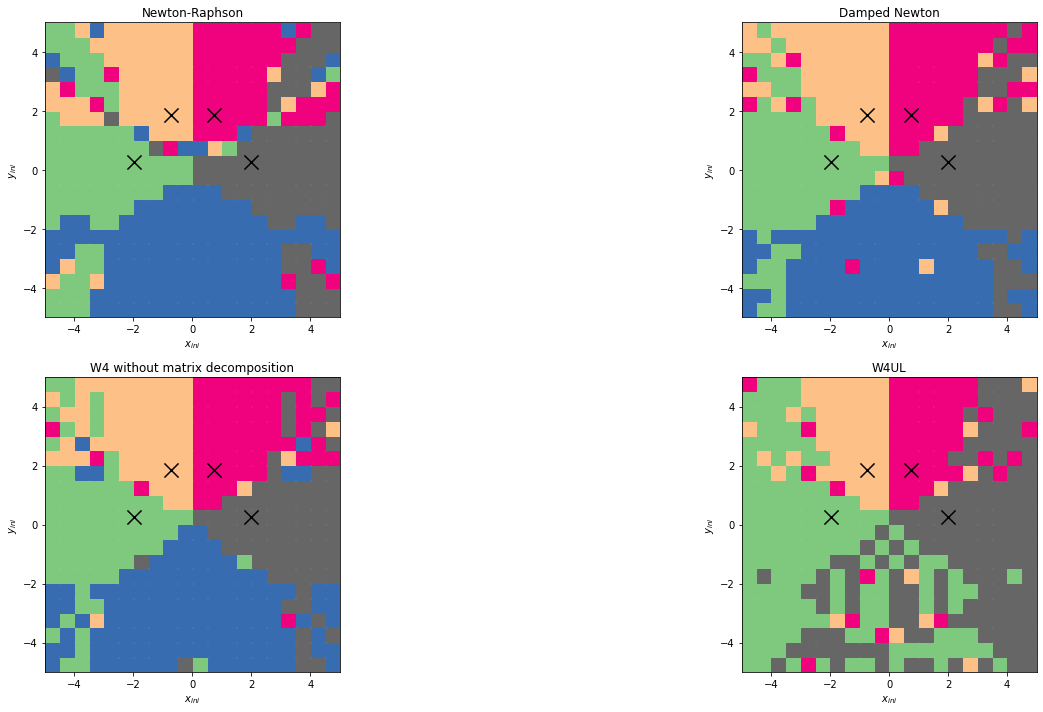

In [15]:
# Plot Basins for Newton-Raphson, W4UL, and W4LH methods

### Four solutions for plots
solx = np.array([]);
soly = np.array([]);

x0=-5.0
y0= 0.5
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

x0=-0.5
y0= 5.0
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

x0=0.5
y0=5.0
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

x0=5.0
y0=0.5
vini = np.array([]);
vini = np.append(vini, x0);
vini = np.append(vini, y0);
vans, iter, err = w4ul(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);
solx = np.append(solx, vans[0]);
soly = np.append(soly, vans[1]);

### Basin Figures
fig = plt.figure(figsize=(24,10));
ax1 = fig.add_subplot(2,2,1);
ax1.scatter(xd_nr,yd_nr,s=200,c=zd_nr,marker='s',cmap='Accent');
ax1.set_xlabel("$x_{ini}$");
ax1.set_ylabel("$y_{ini}$");
ax1.set_xlim(-5,5);
ax1.set_ylim(-5,5);
ax1.set_aspect('equal');
ax1.scatter(solx,soly,s=200,c='black',marker='x');
ax1.set_title("Newton-Raphson");


ax2 = fig.add_subplot(2,2,2);
ax2.scatter(xd_dn,yd_dn,s=200,c=zd_dn,marker='s',cmap='Accent');
ax2.set_xlabel("$x_{ini}$");
ax2.set_ylabel("$y_{ini}$");
ax2.set_xlim(-5,5);
ax2.set_ylim(-5,5);
ax2.set_aspect('equal');
ax2.scatter(solx,soly,s=200,c='black',marker='x');
ax2.set_title("Damped Newton");

ax3 = fig.add_subplot(2,2,3);
ax3.scatter(xd_w4wo,yd_w4wo,s=200,c=zd_w4wo,marker='s',cmap='Accent');
ax3.set_xlabel("$x_{ini}$");
ax3.set_ylabel("$y_{ini}$");
ax3.set_xlim(-5,5);
ax3.set_ylim(-5,5);
ax3.set_aspect('equal');
ax3.scatter(solx,soly,s=200,c='black',marker='x');
ax3.set_title("W4 without matrix decomposition");

ax4 = fig.add_subplot(2,2,4);
ax4.scatter(xd_w4ul,yd_w4ul,s=200,c=zd_w4ul,marker='s',cmap='Accent');
ax4.set_xlabel("$x_{ini}$");
ax4.set_ylabel("$y_{ini}$");
ax4.set_xlim(-5,5);
ax4.set_ylim(-5,5);
ax4.set_aspect('equal');
ax4.scatter(solx,soly,s=200,c='black',marker='x');
ax4.set_title("W4UL");


fig.tight_layout();


# Comments on Basin figures

## How to see the figures
* $x_{ini}$, $y_{ini}$ :: x[0], x[1]
* Black Crosses :: Four solutions to the system of nonlinear equations 
* Color difference :: Different solution which the method finds from the initial guess
* Blue color :: method fails to find any solution

## What we can see
* All methods have the local convergence. (Initial guess close to the solution reaches it.)
* Newton-Raphson method sometimes fails to find a solution as a well-known fact.
* This behavior does not alter when we use the Damped Newton or line-search method.
* Moreover, it cannot change when we introduce the second time derivative term only. (See W4 without any matrix decomposition)
* The W4 method with matrix decomposition such as UL decomposition can solve this problem. (Blue color disappears.)

# Matrix Decomposition is critical!